In [1]:
import gc
import lightgbm as lgb  # type: ignore
import numpy as np  # type: ignore
import pandas as pd  # type: ignore
import polars as pl  # type: ignore
import warnings

from catboost import CatBoostClassifier, Pool  # type: ignore
from glob import glob
from IPython.display import display  # type: ignore
from pathlib import Path
from sklearn.base import BaseEstimator, ClassifierMixin  # type: ignore
from sklearn.metrics import roc_auc_score  # type: ignore
from sklearn.model_selection import StratifiedGroupKFold  # type: ignore
from typing import Any

warnings.filterwarnings("ignore")

ROOT = Path("/kaggle/input/home-credit-credit-risk-model-stability")
TRAIN_DIR = ROOT / "parquet_files" / "train"
TEST_DIR = ROOT / "parquet_files" / "test"

In [2]:
class Utility:
    @staticmethod
    def get_feat_defs(ending_with: str) -> None:
        """
        Retrieves feature definitions from a CSV file based on the specified ending.

        Args:
        - ending_with (str): Ending to filter feature definitions.

        Returns:
        - pl.DataFrame: Filtered feature definitions.
        """
        feat_defs: pl.DataFrame = pl.read_csv(ROOT / "feature_definitions.csv")

        filtered_feats: pl.DataFrame = feat_defs.filter(
            pl.col("Variable").apply(lambda var: var.endswith(ending_with))
        )

        with pl.Config(fmt_str_lengths=200, tbl_rows=-1):
            print(filtered_feats)

        filtered_feats = None
        feat_defs = None

    @staticmethod
    def find_index(lst: list[Any], item: Any) -> int | None:
        """
        Finds the index of an item in a list.

        Args:
        - lst (list): List to search.
        - item (Any): Item to find in the list.

        Returns:
        - int | None: Index of the item if found, otherwise None.
        """
        try:
            return lst.index(item)
        except ValueError:
            return None

    @staticmethod
    def dtype_to_str(dtype: pl.DataType) -> str:
        """
        Converts Polars data type to string representation.

        Args:
        - dtype (pl.DataType): Polars data type.

        Returns:
        - str: String representation of the data type.
        """
        dtype_map = {
            pl.Decimal: "Decimal",
            pl.Float32: "Float32",
            pl.Float64: "Float64",
            pl.UInt8: "UInt8",
            pl.UInt16: "UInt16",
            pl.UInt32: "UInt32",
            pl.UInt64: "UInt64",
            pl.Int8: "Int8",
            pl.Int16: "Int16",
            pl.Int32: "Int32",
            pl.Int64: "Int64",
            pl.Date: "Date",
            pl.Datetime: "Datetime",
            pl.Duration: "Duration",
            pl.Time: "Time",
            pl.Array: "Array",
            pl.List: "List",
            pl.Struct: "Struct",
            pl.String: "String",
            pl.Categorical: "Categorical",
            pl.Enum: "Enum",
            pl.Utf8: "Utf8",
            pl.Binary: "Binary",
            pl.Boolean: "Boolean",
            pl.Null: "Null",
            pl.Object: "Object",
            pl.Unknown: "Unknown",
        }

        return dtype_map.get(dtype)

    @staticmethod
    def find_feat_occur(regex_path: str, ending_with: str) -> pl.DataFrame:
        """
        Finds occurrences of features ending with a specific string in Parquet files.

        Args:
        - regex_path (str): Regular expression to match Parquet file paths.
        - ending_with (str): Ending to filter feature names.

        Returns:
        - pl.DataFrame: DataFrame containing feature definitions, data types, and file locations.
        """
        feat_defs: pl.DataFrame = pl.read_csv(ROOT / "feature_definitions.csv").filter(
            pl.col("Variable").apply(lambda var: var.endswith(ending_with))
        )
        feat_defs.sort(by=["Variable"])

        feats: list[pl.String] = feat_defs["Variable"].to_list()
        feats.sort()

        occurrences: list[list] = [[set(), set()] for _ in range(feat_defs.height)]

        for path in glob(str(regex_path)):
            df_schema: dict = pl.read_parquet_schema(path)

            for feat, dtype in df_schema.items():
                index: int = Utility.find_index(feats, feat)
                if index != None:
                    occurrences[index][0].add(Utility.dtype_to_str(dtype))
                    occurrences[index][1].add(Path(path).stem)

        data_types: list[str] = [None] * feat_defs.height
        file_locs: list[str] = [None] * feat_defs.height

        for i, feat in enumerate(feats):
            data_types[i] = list(occurrences[i][0])
            file_locs[i] = list(occurrences[i][1])

        feat_defs = feat_defs.with_columns(pl.Series(data_types).alias("Data_Type(s)"))
        feat_defs = feat_defs.with_columns(pl.Series(file_locs).alias("File_Loc(s)"))

        return feat_defs

    def reduce_memory_usage(df: pl.DataFrame, name) -> pl.DataFrame:
        """
        Reduces memory usage of a DataFrame by converting column types.

        Args:
        - df (pl.DataFrame): DataFrame to optimize.
        - name (str): Name of the DataFrame.

        Returns:
        - pl.DataFrame: Optimized DataFrame.
        """
        print(
            f"Memory usage of dataframe \"{name}\" is {round(df.estimated_size('mb'), 4)} MB."
        )

        int_types = [
            pl.Int8,
            pl.Int16,
            pl.Int32,
            pl.Int64,
            pl.UInt8,
            pl.UInt16,
            pl.UInt32,
            pl.UInt64,
        ]
        float_types = [pl.Float32, pl.Float64]

        for col in df.columns:
            col_type = df[col].dtype
            if col_type in int_types + float_types:
                c_min = df[col].min()
                c_max = df[col].max()

                if c_min is not None and c_max is not None:
                    if col_type in int_types:
                        if c_min >= 0:
                            if (
                                c_min >= np.iinfo(np.uint8).min
                                and c_max <= np.iinfo(np.uint8).max
                            ):
                                df = df.with_columns(df[col].cast(pl.UInt8))
                            elif (
                                c_min >= np.iinfo(np.uint16).min
                                and c_max <= np.iinfo(np.uint16).max
                            ):
                                df = df.with_columns(df[col].cast(pl.UInt16))
                            elif (
                                c_min >= np.iinfo(np.uint32).min
                                and c_max <= np.iinfo(np.uint32).max
                            ):
                                df = df.with_columns(df[col].cast(pl.UInt32))
                            elif (
                                c_min >= np.iinfo(np.uint64).min
                                and c_max <= np.iinfo(np.uint64).max
                            ):
                                df = df.with_columns(df[col].cast(pl.UInt64))
                        else:
                            if (
                                c_min >= np.iinfo(np.int8).min
                                and c_max <= np.iinfo(np.int8).max
                            ):
                                df = df.with_columns(df[col].cast(pl.Int8))
                            elif (
                                c_min >= np.iinfo(np.int16).min
                                and c_max <= np.iinfo(np.int16).max
                            ):
                                df = df.with_columns(df[col].cast(pl.Int16))
                            elif (
                                c_min >= np.iinfo(np.int32).min
                                and c_max <= np.iinfo(np.int32).max
                            ):
                                df = df.with_columns(df[col].cast(pl.Int32))
                            elif (
                                c_min >= np.iinfo(np.int64).min
                                and c_max <= np.iinfo(np.int64).max
                            ):
                                df = df.with_columns(df[col].cast(pl.Int64))
                    elif col_type in float_types:
                        if (
                            c_min > np.finfo(np.float32).min
                            and c_max < np.finfo(np.float32).max
                        ):
                            df = df.with_columns(df[col].cast(pl.Float32))

        print(
            f"Memory usage of dataframe \"{name}\" became {round(df.estimated_size('mb'), 4)} MB."
        )

        return df

    def to_pandas(df: pl.DataFrame, cat_cols: list[str] = None) -> (pd.DataFrame, list[str]):  # type: ignore
        """
        Converts a Polars DataFrame to a Pandas DataFrame.

        Args:
        - df (pl.DataFrame): Polars DataFrame to convert.
        - cat_cols (list[str]): List of categorical columns. Default is None.

        Returns:
        - (pd.DataFrame, list[str]): Tuple containing the converted Pandas DataFrame and categorical columns.
        """
        df: pd.DataFrame = df.to_pandas()

        if cat_cols is None:
            cat_cols = list(df.select_dtypes("object").columns)

        df[cat_cols] = df[cat_cols].astype("str")

        return df, cat_cols

In [3]:
class Aggregator:
    @staticmethod
    def max_expr(df: pl.LazyFrame) -> list[pl.Series]:
        """
        Generates expressions for calculating maximum values for specific columns.

        Args:
        - df (pl.LazyFrame): Input LazyFrame.

        Returns:
        - list[pl.Series]: List of expressions for maximum values.
        """
        cols: list[str] = [
            col
            for col in df.columns
            if (col[-1] in ("P", "M", "A", "D", "T", "L")) or ("num_group" in col)
        ]

        expr_max: list[pl.Series] = [
            pl.col(col).max().alias(f"max_{col}") for col in cols
        ]

        return expr_max

    @staticmethod
    def min_expr(df: pl.LazyFrame) -> list[pl.Series]:
        """
        Generates expressions for calculating minimum values for specific columns.

        Args:
        - df (pl.LazyFrame): Input LazyFrame.

        Returns:
        - list[pl.Series]: List of expressions for minimum values.
        """
        cols: list[str] = [
            col
            for col in df.columns
            if (col[-1] in ("P", "M", "A", "D", "T", "L")) or ("num_group" in col)
        ]

        expr_min: list[pl.Series] = [
            pl.col(col).min().alias(f"min_{col}") for col in cols
        ]

        return expr_min

    @staticmethod
    def mean_expr(df: pl.LazyFrame) -> list[pl.Series]:
        """
        Generates expressions for calculating mean values for specific columns.

        Args:
        - df (pl.LazyFrame): Input LazyFrame.

        Returns:
        - list[pl.Series]: List of expressions for mean values.
        """
        cols: list[str] = [col for col in df.columns if col.endswith(("P", "A", "D"))]

        expr_mean: list[pl.Series] = [
            pl.col(col).mean().alias(f"mean_{col}") for col in cols
        ]

        return expr_mean

    @staticmethod
    def var_expr(df: pl.LazyFrame) -> list[pl.Series]:
        """
        Generates expressions for calculating variance for specific columns.

        Args:
        - df (pl.LazyFrame): Input LazyFrame.

        Returns:
        - list[pl.Series]: List of expressions for variance.
        """
        cols: list[str] = [col for col in df.columns if col.endswith(("P", "A", "D"))]

        expr_mean: list[pl.Series] = [
            pl.col(col).var().alias(f"var_{col}") for col in cols
        ]

        return expr_mean

    @staticmethod
    def mode_expr(df: pl.LazyFrame) -> list[pl.Series]:
        """
        Generates expressions for calculating mode values for specific columns.

        Args:
        - df (pl.LazyFrame): Input LazyFrame.

        Returns:
        - list[pl.Series]: List of expressions for mode values.
        """
        cols: list[str] = [col for col in df.columns if col.endswith("M")]

        expr_mode: list[pl.Series] = [
            pl.col(col).drop_nulls().mode().first().alias(f"mode_{col}") for col in cols
        ]

        return expr_mode

    @staticmethod
    def get_exprs(df: pl.LazyFrame) -> list[pl.Series]:
        """
        Combines expressions for maximum, mean, and variance calculations.

        Args:
        - df (pl.LazyFrame): Input LazyFrame.

        Returns:
        - list[pl.Series]: List of combined expressions.
        """
        exprs = (
            Aggregator.max_expr(df) + Aggregator.mean_expr(df) + Aggregator.var_expr(df)
        )

        return exprs

In [4]:
class SchemaGen:
    @staticmethod
    def change_dtypes(df: pl.LazyFrame) -> pl.LazyFrame:
        """
        Changes the data types of columns in the DataFrame.

        Args:
        - df (pl.LazyFrame): Input LazyFrame.

        Returns:
        - pl.LazyFrame: LazyFrame with modified data types.
        """
        for col in df.columns:
            if col == "case_id":
                df = df.with_columns(pl.col(col).cast(pl.UInt32).alias(col))
            elif col in ["WEEK_NUM", "num_group1", "num_group2"]:
                df = df.with_columns(pl.col(col).cast(pl.UInt16).alias(col))
            elif col == "date_decision" or col[-1] == "D":
                df = df.with_columns(pl.col(col).cast(pl.Date).alias(col))
            elif col[-1] in ["P", "A"]:
                df = df.with_columns(pl.col(col).cast(pl.Float64).alias(col))
            elif col[-1] in ("M",):
                df = df.with_columns(pl.col(col).cast(pl.String))
        return df

    @staticmethod
    def scan_files(glob_path: str, depth: int = None) -> pl.LazyFrame:
        """
        Scans Parquet files matching the glob pattern and combines them into a LazyFrame.

        Args:
        - glob_path (str): Glob pattern to match Parquet files.
        - depth (int, optional): Depth level for data aggregation. Defaults to None.

        Returns:
        - pl.LazyFrame: Combined LazyFrame.
        """
        chunks: list[pl.LazyFrame] = []
        for path in glob(str(glob_path)):
            df: pl.LazyFrame = pl.scan_parquet(
                path, low_memory=True, rechunk=True
            ).pipe(SchemaGen.change_dtypes)
            print(f"File {Path(path).stem} loaded into memory.")

            if depth in (1, 2):
                exprs: list[pl.Series] = Aggregator.get_exprs(df)
                df = df.group_by("case_id").agg(exprs)

                del exprs
                gc.collect()

            chunks.append(df)

        df = pl.concat(chunks, how="vertical_relaxed")

        del chunks
        gc.collect()

        df = df.unique(subset=["case_id"])

        return df

    @staticmethod
    def join_dataframes(
        df_base: pl.LazyFrame,
        depth_0: list[pl.LazyFrame],
        depth_1: list[pl.LazyFrame],
        depth_2: list[pl.LazyFrame],
    ) -> pl.DataFrame:
        """
        Joins multiple LazyFrames with a base LazyFrame.

        Args:
        - df_base (pl.LazyFrame): Base LazyFrame.
        - depth_0 (list[pl.LazyFrame]): List of LazyFrames for depth 0.
        - depth_1 (list[pl.LazyFrame]): List of LazyFrames for depth 1.
        - depth_2 (list[pl.LazyFrame]): List of LazyFrames for depth 2.

        Returns:
        - pl.DataFrame: Joined DataFrame.
        """
        for i, df in enumerate(depth_0 + depth_1 + depth_2):
            df_base = df_base.join(df, how="left", on="case_id", suffix=f"_{i}")

        return df_base.collect().pipe(Utility.reduce_memory_usage, "df_train")

In [5]:
def collapse_data(df, column, threshold, replace_val="NOTREPVAL"):
    value_counts = df[column].value_counts()
    frequencies = value_counts.with_columns((pl.col("count") / df.height).alias("proportion"))
    replace_keys = frequencies.filter(pl.col("proportion") <= threshold)[column].to_list()
    replace_dict = {key: replace_val for key in replace_keys}
    return [pl.col(column).apply(lambda x: replace_dict.get(x, x))]

In [6]:
def filter_cols(df: pl.DataFrame) -> pl.DataFrame:
    """
    Filters columns in the DataFrame based on null percentage and unique values for string columns.

    Args:
    - df (pl.DataFrame): Input DataFrame.

    Returns:
    - pl.DataFrame: DataFrame with filtered columns.
    """
    for col in df.columns:
        if col not in ["case_id", "year", "month", "week_num", "target"]:
            null_pct = df[col].is_null().mean()

            if null_pct > 0.95:
                df = df.drop(col)

    for col in df.columns:
        if (col not in ["case_id", "year", "month", "week_num", "target"]) & (
            df[col].dtype == pl.String
        ):
            freq = df[col].n_unique()

            if (freq > 200) | (freq == 1):
                df = df.drop(col)

    return df

In [7]:
def transform_cols(df: pl.DataFrame) -> pl.DataFrame:
    """
    Transforms columns in the DataFrame according to predefined rules.

    Args:
    - df (pl.DataFrame): Input DataFrame.

    Returns:
    - pl.DataFrame: DataFrame with transformed columns.
    """
    if "riskassesment_302T" in df.columns:
        if df["riskassesment_302T"].dtype == pl.Null:
            df = df.with_columns(
                [
                    pl.Series(
                        "riskassesment_302T_rng", df["riskassesment_302T"], pl.UInt8
                    ),
                    pl.Series(
                        "riskassesment_302T_mean", df["riskassesment_302T"], pl.UInt8
                    ),
                ]
            )
        else:
            pct_low: pl.Series = (
                df["riskassesment_302T"]
                .str.split(" - ")
                .apply(lambda x: x[0].replace("%", ""))
                .cast(pl.UInt8)
            )
            pct_high: pl.Series = (
                df["riskassesment_302T"]
                .str.split(" - ")
                .apply(lambda x: x[1].replace("%", ""))
                .cast(pl.UInt8)
            )

            diff: pl.Series = pct_high - pct_low
            avg: pl.Series = ((pct_low + pct_high) / 2).cast(pl.Float32)

            del pct_high, pct_low
            gc.collect()

            df = df.with_columns(
                [
                    diff.alias("riskassesment_302T_rng"),
                    avg.alias("riskassesment_302T_mean"),
                ]
            )

        df.drop("riskassesment_302T")

    return df


In [8]:
def handle_dates(df: pl.DataFrame) -> pl.DataFrame:
    """
    Handles date columns in the DataFrame.

    Args:
    - df (pl.DataFrame): Input DataFrame.

    Returns:
    - pl.DataFrame: DataFrame with transformed date columns.
    """
    for col in df.columns:
        if col.endswith("D"):
            df = df.with_columns(pl.col(col) - pl.col("date_decision"))
            df = df.with_columns(pl.col(col).dt.total_days().cast(pl.Int32))

    df = df.rename(
        {
            "MONTH": "month",
            "WEEK_NUM": "week_num"
        }
    )
            
    df = df.with_columns(
        [
            pl.col("date_decision").dt.year().alias("year").cast(pl.Int16),
            pl.col("date_decision").dt.day().alias("day").cast(pl.UInt8),
        ]
    )

    return df.drop("date_decision")

In [9]:
data_store: dict = {
    "df_base": SchemaGen.scan_files(TRAIN_DIR / "train_base.parquet")
}

File train_base loaded into memory.


In [10]:
data_store.update({    "depth_0": [
        SchemaGen.scan_files(TRAIN_DIR / "train_static_cb_0.parquet"),
        SchemaGen.scan_files(TRAIN_DIR / "train_static_0_*.parquet"),
    ]
})

File train_static_cb_0 loaded into memory.
File train_static_0_0 loaded into memory.
File train_static_0_1 loaded into memory.


In [11]:
data_store.update({    "depth_1": [
        SchemaGen.scan_files(TRAIN_DIR / "train_applprev_1_*.parquet", 1),
        SchemaGen.scan_files(TRAIN_DIR / "train_tax_registry_a_1.parquet", 1),
        SchemaGen.scan_files(TRAIN_DIR / "train_tax_registry_b_1.parquet", 1),
        SchemaGen.scan_files(TRAIN_DIR / "train_tax_registry_c_1.parquet", 1),
        SchemaGen.scan_files(TRAIN_DIR / "train_credit_bureau_a_1_*.parquet", 1),
        SchemaGen.scan_files(TRAIN_DIR / "train_credit_bureau_b_1.parquet", 1),
        SchemaGen.scan_files(TRAIN_DIR / "train_other_1.parquet", 1),
        SchemaGen.scan_files(TRAIN_DIR / "train_person_1.parquet", 1),
        SchemaGen.scan_files(TRAIN_DIR / "train_deposit_1.parquet", 1),
        SchemaGen.scan_files(TRAIN_DIR / "train_debitcard_1.parquet", 1),
    ]
})

File train_applprev_1_1 loaded into memory.
File train_applprev_1_0 loaded into memory.
File train_tax_registry_a_1 loaded into memory.
File train_tax_registry_b_1 loaded into memory.
File train_tax_registry_c_1 loaded into memory.
File train_credit_bureau_a_1_3 loaded into memory.
File train_credit_bureau_a_1_2 loaded into memory.
File train_credit_bureau_a_1_0 loaded into memory.
File train_credit_bureau_a_1_1 loaded into memory.
File train_credit_bureau_b_1 loaded into memory.
File train_other_1 loaded into memory.
File train_person_1 loaded into memory.
File train_deposit_1 loaded into memory.
File train_debitcard_1 loaded into memory.


In [12]:
data_store.update({    "depth_2": [
        SchemaGen.scan_files(TRAIN_DIR / "train_credit_bureau_a_2_*.parquet", 2),
        SchemaGen.scan_files(TRAIN_DIR / "train_credit_bureau_b_2.parquet", 2),
    ]
})

File train_credit_bureau_a_2_6 loaded into memory.
File train_credit_bureau_a_2_1 loaded into memory.
File train_credit_bureau_a_2_0 loaded into memory.
File train_credit_bureau_a_2_7 loaded into memory.
File train_credit_bureau_a_2_5 loaded into memory.
File train_credit_bureau_a_2_2 loaded into memory.
File train_credit_bureau_a_2_4 loaded into memory.
File train_credit_bureau_a_2_9 loaded into memory.
File train_credit_bureau_a_2_3 loaded into memory.
File train_credit_bureau_a_2_10 loaded into memory.
File train_credit_bureau_a_2_8 loaded into memory.
File train_credit_bureau_b_2 loaded into memory.


In [13]:
df_train: pl.LazyFrame = (
    SchemaGen.join_dataframes(**data_store)
    .pipe(filter_cols)
    .pipe(transform_cols)
    .pipe(handle_dates)
    .pipe(Utility.reduce_memory_usage, "df_train")
)
del data_store
gc.collect()

print(f"Train data shape: {df_train.shape}")
display(df_train.head(10))

Memory usage of dataframe "df_train" is 6783.1317 MB.
Memory usage of dataframe "df_train" became 4174.0953 MB.
Memory usage of dataframe "df_train" is 2870.9171 MB.
Memory usage of dataframe "df_train" became 2665.6302 MB.
Train data shape: (1526659, 472)


case_id,month,week_num,target,assignmentdate_238D,assignmentdate_4527235D,birthdate_574D,contractssum_5085716L,dateofbirth_337D,days120_123L,days180_256L,days30_165L,days360_512L,days90_310L,description_5085714M,education_1103M,education_88M,firstquarter_103L,fourthquarter_440L,maritalst_385M,maritalst_893M,numberofqueries_373L,pmtaverage_3A,pmtaverage_4527227A,pmtcount_4527229L,pmtcount_693L,pmtscount_423L,pmtssum_45A,requesttype_4525192L,responsedate_1012D,responsedate_4527233D,responsedate_4917613D,secondquarter_766L,thirdquarter_1082L,actualdpdtolerance_344P,amtinstpaidbefduel24m_4187115A,annuity_780A,…,mean_mainoccupationinc_384A,max_amount_416A,max_num_group1_10,max_openingdate_313D,mean_amount_416A,mean_openingdate_313D,max_num_group1_11,max_openingdate_857D,mean_openingdate_857D,max_collater_typofvalofguarant_298M,max_collater_typofvalofguarant_407M,max_collater_valueofguarantee_1124L,max_collater_valueofguarantee_876L,max_collaterals_typeofguarante_359M,max_collaterals_typeofguarante_669M,max_num_group1_12,max_num_group2,max_pmts_dpd_1073P,max_pmts_dpd_303P,max_pmts_month_158T,max_pmts_month_706T,max_pmts_overdue_1140A,max_pmts_overdue_1152A,max_pmts_year_1139T,max_pmts_year_507T,max_subjectroles_name_541M,max_subjectroles_name_838M,mean_pmts_dpd_1073P,mean_pmts_dpd_303P,mean_pmts_overdue_1140A,mean_pmts_overdue_1152A,var_pmts_dpd_1073P,var_pmts_dpd_303P,var_pmts_overdue_1140A,var_pmts_overdue_1152A,year,day
u32,u32,u8,u8,i16,u8,i16,f32,i32,f32,f32,f32,f32,f32,str,str,str,f32,f32,str,str,f32,f32,f32,f32,f32,f32,f32,str,i8,u8,i8,f32,f32,f32,f32,f32,…,f32,f32,u8,i16,f32,i16,u8,i16,i16,str,str,f32,f32,str,str,u16,u8,f32,f32,f32,f32,f32,f32,f32,f32,str,str,f32,f32,f32,f32,f32,f32,f32,f32,u16,u8
2591591,201907,26,0,null,null,-17563,null,-17563,1.0,1.0,0.0,6.0,1.0,"""a55475b1""","""6b2ae0fa""","""a55475b1""",1.0,4.0,"""3439d993""","""a55475b1""",6.0,null,null,null,null,5.0,4612.434082,null,14,null,null,1.0,4.0,0.0,119398.601562,8727.400391,…,50000.0,null,null,null,null,null,null,null,null,"""a55475b1""","""a55475b1""",0.0,0.0,"""c7a5ad39""","""c7a5ad39""",3,35,0.0,0.0,12.0,12.0,0.0,0.0,2020.0,2019.0,"""ab3c25cf""","""ab3c25cf""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019,2
2623228,201909,37,0,null,null,null,null,-12589,0.0,0.0,0.0,0.0,0.0,"""a55475b1""","""6b2ae0fa""","""a55475b1""",3.0,1.0,"""3439d993""","""a55475b1""",0.0,null,null,null,null,8.0,13567.799805,"""DEDUCTION_6""",14,14,null,0.0,0.0,0.0,0.0,4407.800293,…,58000.0,null,null,null,null,null,null,null,null,"""a55475b1""","""a55475b1""",0.0,0.0,"""c7a5ad39""","""c7a5ad39""",5,35,3.0,35.0,12.0,12.0,7951.850098,8542.057617,2020.0,2019.0,"""ab3c25cf""","""ab3c25cf""",0.069767,1.671233,184.926743,708.026245,0.209302,39.362633,1.4705e6,3.4149e6,2019,19
707353,201906,22,0,-585,null,-21800,null,-21800,0.0,0.0,0.0,0.0,0.0,"""a55475b1""","""a55475b1""","""a55475b1""",0.0,0.0,"""a55475b1""","""a55475b1""",0.0,5446.399902,null,null,6.0,null,null,null,14,null,null,0.0,0.0,null,null,2206.0,…,30000.0,null,null,null,null,null,null,null,null,"""a55475b1""","""a55475b1""",0.0,null,"""a55475b1""","""c7a5ad39""",0,35,0.0,null,12.0,null,0.0,null,2020.0,null,"""a55475b1""","""ab3c25cf""",0.0,null,0.0,null,0.0,null,0.0,null,2019,8
2550999,201903,10,0,null,null,-16751,null,-16751,5.0,7.0,0.0,9.0,3.0,"""a55475b1""","""717ddd49""","""a55475b1""",5.0,2.0,"""38c061ee""","""a55475b1""",9.0,null,null,null,null,7.0,12861.875977,null,14,null,null,5.0,10.0,0.0,null,772.200012,…,26000.0,null,null,null,null,null,null,null,null,"""a55475b1""","""a55475b1""",0.0,null,"""a55475b1""","""c7a5ad39""",1,23,0.0,null,12.0,null,0.0,null,2020.0,null,"""a55475b1""","""ab3c25cf""",0.0,null,0.0,null,0.0,null,0.0,null,2019,12
893058,201912,49,0,null,null,null,null,-14253,0.0,0.0,0.0,0.0,0.0,"""a55475b1""","""717ddd49""","""a55475b1""",2.0,1.0,"""3439d993""","""a55475b1""",0.0,null,null,null,null,null,null,"""DEDUCTION_6""",null,14,null,0.0,1.0,null,null,1523.599976,…,60000.0,null,null,null,null,null,null,null,null,"""a5

In [14]:
data_store: dict = {
    "df_base": SchemaGen.scan_files(TEST_DIR / "test_base.parquet"),
    "depth_0": [
        SchemaGen.scan_files(TEST_DIR / "test_static_cb_0.parquet"),
        SchemaGen.scan_files(TEST_DIR / "test_static_0_*.parquet"),
    ],
    "depth_1": [
        SchemaGen.scan_files(TEST_DIR / "test_applprev_1_*.parquet", 1),
        SchemaGen.scan_files(TEST_DIR / "test_tax_registry_a_1.parquet", 1),
        SchemaGen.scan_files(TEST_DIR / "test_tax_registry_b_1.parquet", 1),
        SchemaGen.scan_files(TEST_DIR / "test_tax_registry_c_1.parquet", 1),
        SchemaGen.scan_files(TEST_DIR / "test_credit_bureau_a_1_*.parquet", 1),
        SchemaGen.scan_files(TEST_DIR / "test_credit_bureau_b_1.parquet", 1),
        SchemaGen.scan_files(TEST_DIR / "test_other_1.parquet", 1),
        SchemaGen.scan_files(TEST_DIR / "test_person_1.parquet", 1),
        SchemaGen.scan_files(TEST_DIR / "test_deposit_1.parquet", 1),
        SchemaGen.scan_files(TEST_DIR / "test_debitcard_1.parquet", 1),
    ],
    "depth_2": [
        SchemaGen.scan_files(TEST_DIR / "test_credit_bureau_a_2_*.parquet", 2),
        SchemaGen.scan_files(TEST_DIR / "test_credit_bureau_b_2.parquet", 2),
    ],
}

File test_base loaded into memory.
File test_static_cb_0 loaded into memory.
File test_static_0_0 loaded into memory.
File test_static_0_2 loaded into memory.
File test_static_0_1 loaded into memory.
File test_applprev_1_2 loaded into memory.
File test_applprev_1_0 loaded into memory.
File test_applprev_1_1 loaded into memory.
File test_tax_registry_a_1 loaded into memory.
File test_tax_registry_b_1 loaded into memory.
File test_tax_registry_c_1 loaded into memory.
File test_credit_bureau_a_1_3 loaded into memory.
File test_credit_bureau_a_1_2 loaded into memory.
File test_credit_bureau_a_1_1 loaded into memory.
File test_credit_bureau_a_1_4 loaded into memory.
File test_credit_bureau_a_1_0 loaded into memory.
File test_credit_bureau_b_1 loaded into memory.
File test_other_1 loaded into memory.
File test_person_1 loaded into memory.
File test_deposit_1 loaded into memory.
File test_debitcard_1 loaded into memory.
File test_credit_bureau_a_2_3 loaded into memory.
File test_credit_bureau

In [15]:
df_test: pl.DataFrame = (
    SchemaGen.join_dataframes(**data_store)
    .pipe(transform_cols)
    .pipe(handle_dates)
    .select([col for col in df_train.columns if col != "target"])
    .pipe(Utility.reduce_memory_usage, "df_test")
)
del data_store
gc.collect()

print(f"Test data shape: {df_test.shape}")

Memory usage of dataframe "df_train" is 0.0432 MB.
Memory usage of dataframe "df_train" became 0.0311 MB.
Memory usage of dataframe "df_test" is 0.0184 MB.
Memory usage of dataframe "df_test" became 0.0172 MB.
Test data shape: (10, 471)


In [16]:
num_cols_1 = ['secondquarter_766L', 'numinstlswithdpd10_728L', 'mean_dateactivated_425D', 'mean_credamount_590A', 'max_dtlastpmt_581D', 'totaldebt_9A', 'clientscnt_304L', 'max_dateactivated_425D', 'clientscnt_887L', 'numinstregularpaidest_4493210L', 'mean_lastupdate_1112D', 'mean_overdueamountmax2_14A', 'max_overdueamountmax2date_1142D', 'max_debtoutstand_525A', 'max_periodicityofpmts_837L', 'mean_dtlastpmtallstes_3545839D', 'last_pmtnum_8L', 'mean_approvaldate_319D', 'last_credacc_credlmt_575A', 'last_pmts_month_706T', 'pctinstlsallpaidlate1d_3546856L', 'max_overdueamountmaxdateyear_994T', 'max_dtlastpmtallstes_3545839D', 'maxannuity_159A', 'firstclxcampaign_1125D', 'pmtssum_45A', 'max_debtoverdue_47A', 'numinsttopaygr_769L', 'mastercontrelectronic_519L', 'applications30d_658L', 'pmtscount_423L', 'lastactivateddate_801D', 'mindbdtollast24m_4525191P', 'dateofbirth_337D', 'max_byoccupationinc_3656910L', 'max_numberofcontrsvalue_358L', 'max_pmts_dpd_303P', 'firstdatedue_489D', 'mean_creationdate_885D', 'cntincpaycont9m_3716944L', 'mean_monthlyinstlamount_674A', 'responsedate_1012D', 'max_numberofoutstandinstls_59L', 'last_num_group1', 'mean_numberofoverdueinstlmaxdat_641D', 'maxdpdfrom6mto36m_3546853P', 'amtinstpaidbefduel24m_4187115A', 'mean_overdueamountmax2date_1002D', 'disbursedcredamount_1113A', 'price_1097A', 'max_outstandingdebt_522A', 'maxdpdlast3m_392P', 'last_mainoccupationinc_384A', 'max_downpmt_134A', 'max_num_group1_9', 'numpmtchanneldd_318L', 'last_num_group2_14', 'max_dateofcredstart_181D', 'numnotactivated_1143L']
num_cols_2=['max_collater_valueofguarantee_876L', 'daysoverduetolerancedd_3976961L', 'max_dateofrealrepmt_138D', 'applicationscnt_867L', 'mean_mainoccupationinc_437A', 'sumoutstandtotal_3546847A', 'max_approvaldate_319D', 'mean_credlmt_935A', 'clientscnt_157L', 'homephncnt_628L', 'max_numberofoverdueinstlmax_1039L', 'lastapprdate_640D', 'numrejects9m_859L', 'sumoutstandtotalest_4493215A', 'max_pmts_month_706T', 'avginstallast24m_3658937A', 'maxdbddpdtollast6m_4187119P', 'max_dpdmaxdatemonth_89T', 'pctinstlsallpaidlat10d_839L', 'fourthquarter_440L', 'max_dpdmaxdateyear_896T', 'pctinstlsallpaidlate6d_3546844L', 'mean_actualdpd_943P', 'birthdate_574D', 'max_credamount_590A', 'thirdquarter_1082L', 'mean_pmts_dpd_303P', 'last_persontype_1072L', 'firstquarter_103L', 'maxdbddpdlast1m_3658939P', 'maxdbddpdtollast12m_3658940P', 'mean_dtlastpmt_581D', 'last_dtlastpmtallstes_3545839D', 'weekday_decision', 'avgdpdtolclosure24_3658938P', 'commnoinclast6m_3546845L', 'max_num_group1', 'last_pmts_month_158T', 'annuitynextmonth_57A', 'max_overdueamountmaxdatemonth_284T', 'maxdebt4_972A', 'max_pmts_year_1139T', 'avgdbddpdlast3m_4187120P', 'last_maxdpdtolerance_577P', 'max_residualamount_488A', 'clientscnt_1130L', 'max_lastupdate_1112D', 'mean_outstandingamount_362A', 'max_periodicityofpmts_1102L', 'last_dateactivated_425D', 'max_num_group2_14', 'max_monthlyinstlamount_674A', 'mean_credlmt_230A', 'dtlastpmtallstes_4499206D', 'lastdelinqdate_224D', 'eir_270L', 'downpmt_116A', 'maxdpdlast24m_143P', 'maininc_215A', 'actualdpdtolerance_344P', 'applicationscnt_464L', 'last_creationdate_885D', 'last_outstandingdebt_522A']

In [22]:
num_cols_3=[ 'days360_512L', 'max_currdebt_94A', 'last_employedfrom_700D', 'mobilephncnt_593L', 'mean_pmts_overdue_1152A', 'month_decision', 'numinstpaidlate1d_3546852L', 'pmtnum_254L', 'credamount_770A', 'max_numberofinstls_229L', 'clientscnt_100L', 'posfpd10lastmonth_333P', 'mean_totaloutstanddebtvalue_39A', 'max_dpdmaxdatemonth_442T', 'clientscnt_1022L', 'clientscnt_257L', 'mean_totalamount_996A', 'last_birth_259D', 'mean_annuity_853A', 'sellerplacecnt_915L', 'mean_refreshdate_3813885D', 'max_num_group2_15', 'max_dpdmaxdateyear_596T', 'max_num_group1_13', 'lastapprcredamount_781A', 'max_totalamount_6A', 'avgpmtlast12m_4525200A', 'pctinstlsallpaidlate4d_3546849L', 'avgmaxdpdlast9m_3716943P', 'max_annuity_853A', 'numinstlsallpaid_934L', 'deferredmnthsnum_166L', 'mindbddpdlast24m_3658935P', 'clientscnt_360L', 'mean_overdueamount_659A', 'last_num_group1_6', 'clientscnt_533L', 'numinstpaidearly5dest_4493211L', 'numactivecredschannel_414L', 'mean_currdebt_94A', 'numincomingpmts_3546848L', 'max_dateofcredend_353D', 'max_pmts_month_158T', 'cntpmts24_3658933L', 'datefirstoffer_1144D', 'max_numberofoverdueinstls_725L', 'max_credacc_credlmt_575A', 'last_num_group2_13', 'mastercontrexist_109L', 'last_currdebt_94A', 'numinstpaidearly5d_1087L', 'mean_downpmt_134A', 'last_pmts_year_1139T', 'last_processingdate_168D', 'numactivecreds_622L', 'last_actualdpd_943P', 'mean_dpdmax_757P', 'last_credamount_590A', 'last_mainoccupationinc_437A', 'max_num_group2_13', 'max_employedfrom_700D', 'max_numberofoverdueinstlmaxdat_148D', 'mean_firstnonzeroinstldate_307D', 'maxdpdinstlnum_3546846P', 'max_childnum_21L', 'numinstls_657L', 'last_firstnonzeroinstldate_307D', 'posfpd30lastmonth_3976960P', 'totalsettled_863A', 'lastrejectdate_50D', 'max_firstnonzeroinstldate_307D', 'max_overdueamountmaxdatemonth_365T', 'numinstpaidearly3d_3546850L', 'last_approvaldate_319D', 'avgoutstandbalancel6m_4187114A', 'mean_lastupdate_388D', 'max_num_group1_5', 'max_nominalrate_498L', 'mean_monthlyinstlamount_332A']
mum_cols_4=[ 'clientscnt_946L', 'mean_totaloutstanddebtvalue_668A', 'max_pmts_year_507T', 'max_mainoccupationinc_384A', 'clientscnt_493L', 'max_nominalrate_281L', 'max_collater_valueofguarantee_1124L', 'numinstlswithoutdpd_562L', 'max_pmtamount_36A', 'numinstregularpaid_973L', 'posfstqpd30lastmonth_3976962P', 'max_numberofoverdueinstls_834L', 'max_empl_employedfrom_271D', 'mean_dateofcredstart_739D', 'mean_credacc_credlmt_575A', 'mean_totalamount_6A', 'max_pmtnum_8L', 'lastapplicationdate_877D', 'last_personindex_1023L', 'mean_totaldebtoverduevalue_718A', 'mean_instlamount_768A', 'max_num_group1_15', 'last_pmts_year_507T', 'max_overdueamountmaxdateyear_2T', 'maxinstallast24m_3658928A', 'mean_overdueamountmax_35A', 'currdebtcredtyperange_828A', 'max_numberofoutstandinstls_520L', 'max_lastupdate_388D', 'max_processingdate_168D', 'max_numberofcontrsvalue_258L', 'numactiverelcontr_750L', 'max_refreshdate_3813885D', 'max_numberofinstls_320L', 'max_mainoccupationinc_437A', 'mean_dateofrealrepmt_138D', 'max_birth_259D', 'numinstlswithdpd5_4187116L', 'mean_maxdpdtolerance_577P', 'maxlnamtstart6m_4525199A', 'currdebt_22A', 'datelastunpaid_3546854D', 'maxdpdtolerance_374P', 'mean_pmts_overdue_1140A', 'mean_dateofcredend_289D', 'mean_overdueamountmax2_398A', 'last_downpmt_134A', 'maxoutstandbalancel12m_4187113A', 'last_annuity_853A', 'clientscnt_1071L', 'lastrejectcredamount_222A', 'numinstpaid_4499208L', 'mean_overdueamount_31A', 'numcontrs3months_479L', 'applicationscnt_1086L', 'days30_165L', 'maxdpdinstldate_3546855D', 'applicationcnt_361L', 'numinstpaidearly_338L', 'mean_outstandingdebt_522A', 'max_numberofoverdueinstlmax_1151L', 'last_pmtamount_36A', 'mean_pmts_dpd_1073P', 'numinstpaidlastcontr_4325080L', 'pctinstlsallpaidearl3d_427L', 'responsedate_4527233D', 'days180_256L', 'mean_dateofcredend_353D', 'mean_outstandingamount_354A', 'mean_residualamount_856A']

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
def visualize_distribution(df, num_cols):
    # Create a list to store the columns' data
    data = []
    new_num_col_name=[]
    # Loop through the columns and filter by num_cols
    for col in df.columns:
        if col in num_cols:
            data.append(df[col])
            new_num_col_name.append(col)
    # Create a new DataFrame with only the selected columns
    df_filtered = pl.DataFrame({col: df[col] for col in new_num_col_name})
    
    # Convert the filtered DataFrame to long format
    df_melted = df_filtered.melt(id_vars=None, variable_name='Columns', value_name='Values')

    # Convert the Polars DataFrame to a Pandas DataFrame for plotting
    df_melted_pandas = df_melted.to_pandas()

    # Create the plot
    plt.figure(figsize=(10, 6))
    sns.violinplot(x='Values', y='Columns', data=df_melted_pandas, inner=None)
    sns.stripplot(x='Values', y='Columns', data=df_melted_pandas, color='k', alpha=0.5, jitter=True)
    sns.boxplot(x='Values', y='Columns',data=df_melted_pandas,)
    # Add titles and labels
    plt.title('Distribution of Values across Different Columns')
    plt.xlabel('Values')
    plt.ylabel('Columns')
    
    # Show the plot
    plt.show()

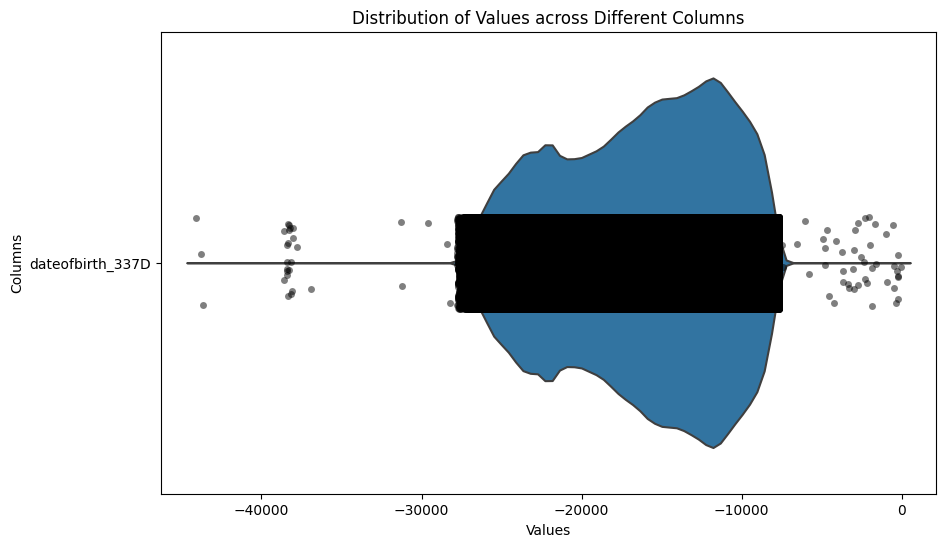

In [28]:
visualize_distribution(df_train,'dateofbirth_337D')

In [27]:
visualize_distribution(df_train,num_cols_2)

KeyboardInterrupt: 

<Figure size 1000x600 with 0 Axes>

In [ ]:
visualize_distribution(df_train,num_cols_3)

In [ ]:
visualize_distribution(df_train,num_cols_4)

In [21]:
for col in df_train.columns:
    if col in num_cols:
        
        )

SyntaxError: unmatched ')' (2546084273.py, line 4)

In [ ]:
for col in df_test.columns:
    if col in num_cols:
        df_test = df_test.with_columns(
            pl.col(col).fill_null(-0.2)
        )

In [ ]:
df_train, cat_cols = Utility.to_pandas(df_train)
df_test, cat_cols = Utility.to_pandas(df_test, cat_cols)

In [ ]:
class VotingModel(BaseEstimator, ClassifierMixin):
    """
    A voting ensemble model that combines predictions from multiple estimators.

    Parameters:
    - estimators (list): List of base estimators.

    Attributes:
    - estimators (list): List of base estimators.

    Methods:
    - fit(X, y=None): Fit the model to the training data.
    - predict(X): Predict class labels for samples.
    - predict_proba(X): Predict class probabilities for samples.
    """

    def __init__(self, estimators: list[BaseEstimator]):
        """
        Initialize the VotingModel with a list of base estimators.

        Args:
        - estimators (list): List of base estimators.
        """
        super().__init__()
        self.estimators = estimators

    def fit(self, X, y=None):
        """
        Fit the model to the training data.

        Args:
        - X: Input features.
        - y: Target labels (ignored).

        Returns:
        - self: Returns the instance itself.
        """
        return self

    def predict(self, X):
        """
        Predict class labels for samples.

        Args:
        - X: Input features.

        Returns:
        - numpy.ndarray: Predicted class labels.
        """
        y_preds = [estimator.predict(X) for estimator in self.estimators]
        return np.mean(y_preds, axis=0)

    def predict_proba(self, X):
        """
        Predict class probabilities for samples.

        Args:
        - X: Input features.

        Returns:
        - numpy.ndarray: Predicted class probabilities.
        """
        y_preds = [estimator.predict_proba(X) for estimator in self.estimators]
        return np.mean(y_preds, axis=0)

In [ ]:
df_subm: pd.DataFrame = pd.read_csv(ROOT / "sample_submission.csv")
df_subm = df_subm.set_index("case_id")

device: str = "gpu"
est_cnt: int = 6000

DRY_RUN = True if df_subm.shape[0] == 10 else False
if DRY_RUN:
    device = "cpu"
    df_train = df_train.iloc[:50000]
    est_cnt: int = 600

print(device)

In [ ]:
print(f"Train data shape: {df_train.shape}")
display(df_train.head(10))

In [ ]:
X = df_train.drop(columns=["target", "case_id", "week_num"])
y = df_train["target"]

weeks = df_train["week_num"]

del df_train
gc.collect()

cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

params1 = {
    'max_depth': 10, 
    'learning_rate': 0.08782012462087778, 
    'n_estimators': 2407, 
    'colsample_bytree': 0.7334424703349294, 
    'colsample_bynode': 0.7061902478467862, 
    'reg_lambda': 11.462691473291214, 
    'num_leaves': 71
}

params2 = {
    'max_depth': 10, 
    'learning_rate': 0.08152947716317403, 
    'n_estimators': 2258, 
    'colsample_bytree': 0.7480805378110842, 
    'colsample_bynode': 0.5224328234091795, 
    'reg_lambda': 11.170849097981652, 
    'num_leaves': 62
}

fitted_models_cat = []
fitted_models_lgb = []

cv_scores_cat = []
cv_scores_lgb = []

iter_cnt = 0
for idx_train, idx_valid in cv.split(X, y, groups=weeks):
    X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
    X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

    train_pool = Pool(X_train, y_train, cat_features=cat_cols)
    val_pool = Pool(X_valid, y_valid, cat_features=cat_cols)

    clf = CatBoostClassifier(
        best_model_min_trees = 1000,
        boosting_type = "Plain",
        eval_metric = "AUC",
        iterations = 2752,
        learning_rate = 0.04421254142471941,
        l2_leaf_reg = 10,
        max_leaves = 64,
        random_seed = 42,
        task_type = "GPU",
        use_best_model = True
    )

    clf.fit(train_pool, eval_set=val_pool, verbose=False)
    fitted_models_cat.append(clf)

    y_pred_valid = clf.predict_proba(X_valid)[:, 1]
    auc_score = roc_auc_score(y_valid, y_pred_valid)
    cv_scores_cat.append(auc_score)

    X_train[cat_cols] = X_train[cat_cols].astype("category")
    X_valid[cat_cols] = X_valid[cat_cols].astype("category")

    if iter_cnt % 2 == 0:
        model = lgb.LGBMClassifier(**params1)
    else:
        model = lgb.LGBMClassifier(**params2)

    model.fit(
        X_train,
        y_train,
        eval_set=[(X_valid, y_valid)],
        callbacks=[lgb.log_evaluation(100), lgb.early_stopping(100)],
    )
    fitted_models_lgb.append(model)

    y_pred_valid = model.predict_proba(X_valid)[:, 1]
    auc_score = roc_auc_score(y_valid, y_pred_valid)
    cv_scores_lgb.append(auc_score)

    iter_cnt += 1

model = VotingModel(fitted_models_cat + fitted_models_lgb)

print(f"\nCV AUC scores for CatBoost: {cv_scores_cat}")
print(f"Maximum CV AUC score for Catboost: {max(cv_scores_cat)}", end="\n\n")


print(f"CV AUC scores for LGBM: {cv_scores_lgb}")
print(f"Maximum CV AUC score for LGBM: {max(cv_scores_lgb)}", end="\n\n")

del X, y
gc.collect()

In [ ]:
X_test: pd.DataFrame = df_test.drop(columns=["week_num"]).set_index("case_id")

X_test[cat_cols] = X_test[cat_cols].astype("category")

y_pred: pd.Series = pd.Series(model.predict_proba(X_test)[:, 1], index=X_test.index)

df_subm["score"] = y_pred

display(df_subm)

df_subm.to_csv("submission.csv")

del X_test, y_pred, df_subm
gc.collect()